In [2]:
from pystac_client import Client
import stackstac

import warnings
warnings.filterwarnings('ignore')

In [3]:
box = [-122.51006, 37.70801, -122.36268, 37.80668]
client = Client.open("https://earth-search.aws.element84.com/v1")
search = client.search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2022-06-01/2022-08-01",
    query={"eo:cloud_cover": {"lt": 20}}
)

In [4]:
items = search.get_all_items()
stack = stackstac.stack(items, bounds_latlon=box)
stack

<xarray.DataArray 'stackstac-3466bdd0ed40d4a169e72846a59289a4' (time: 3,
                                                                band: 32,
                                                                y: 1103, x: 1306)>
dask.array<fetch_raster_window, shape=(3, 32, 1103, 1306), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-06-13...
    id                                       (time) <U24 'S2A_10SEG_20220613_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 5.431e+05 ... 5.562e+05
  * y                                        (y) float64 4.185e+06 ... 4.174e+06
    s2:high_proba_clouds_percentage          (time) float64 0.006009 ... 1.922
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(543120.0, 4173530.0, 556180.0...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 543120.00|\n| 0.00,-10.00, 4184560.00|\n| 0.0...
    resolution:  10.0

In [5]:
red = stack.sel(band="red")
nir = stack.sel(band="nir")

In [6]:
print("computing ndvi...")
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    ndvi = ( ((nir - red) / (red + nir)).
            resample(time="MS").
            median("time", keep_attrs=True).
            compute()
    )

computing ndvi...
[########################################] | 100% Completed | 3.41 ss


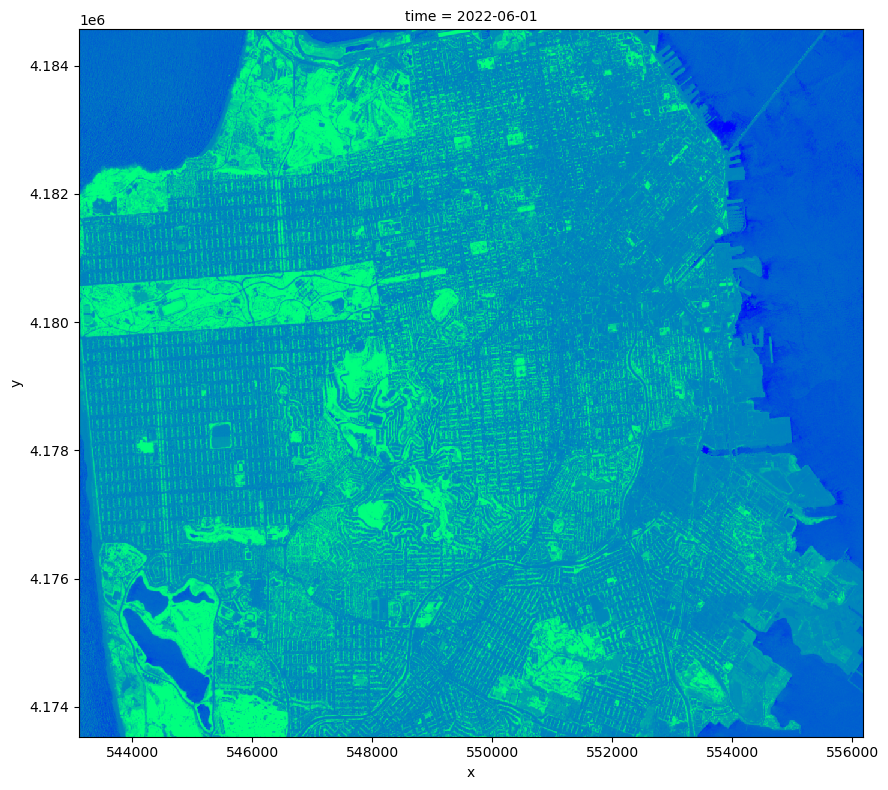

In [7]:
ndvi.plot.imshow(row="time", cmap="winter", robust=True, add_colorbar=False, size=8)


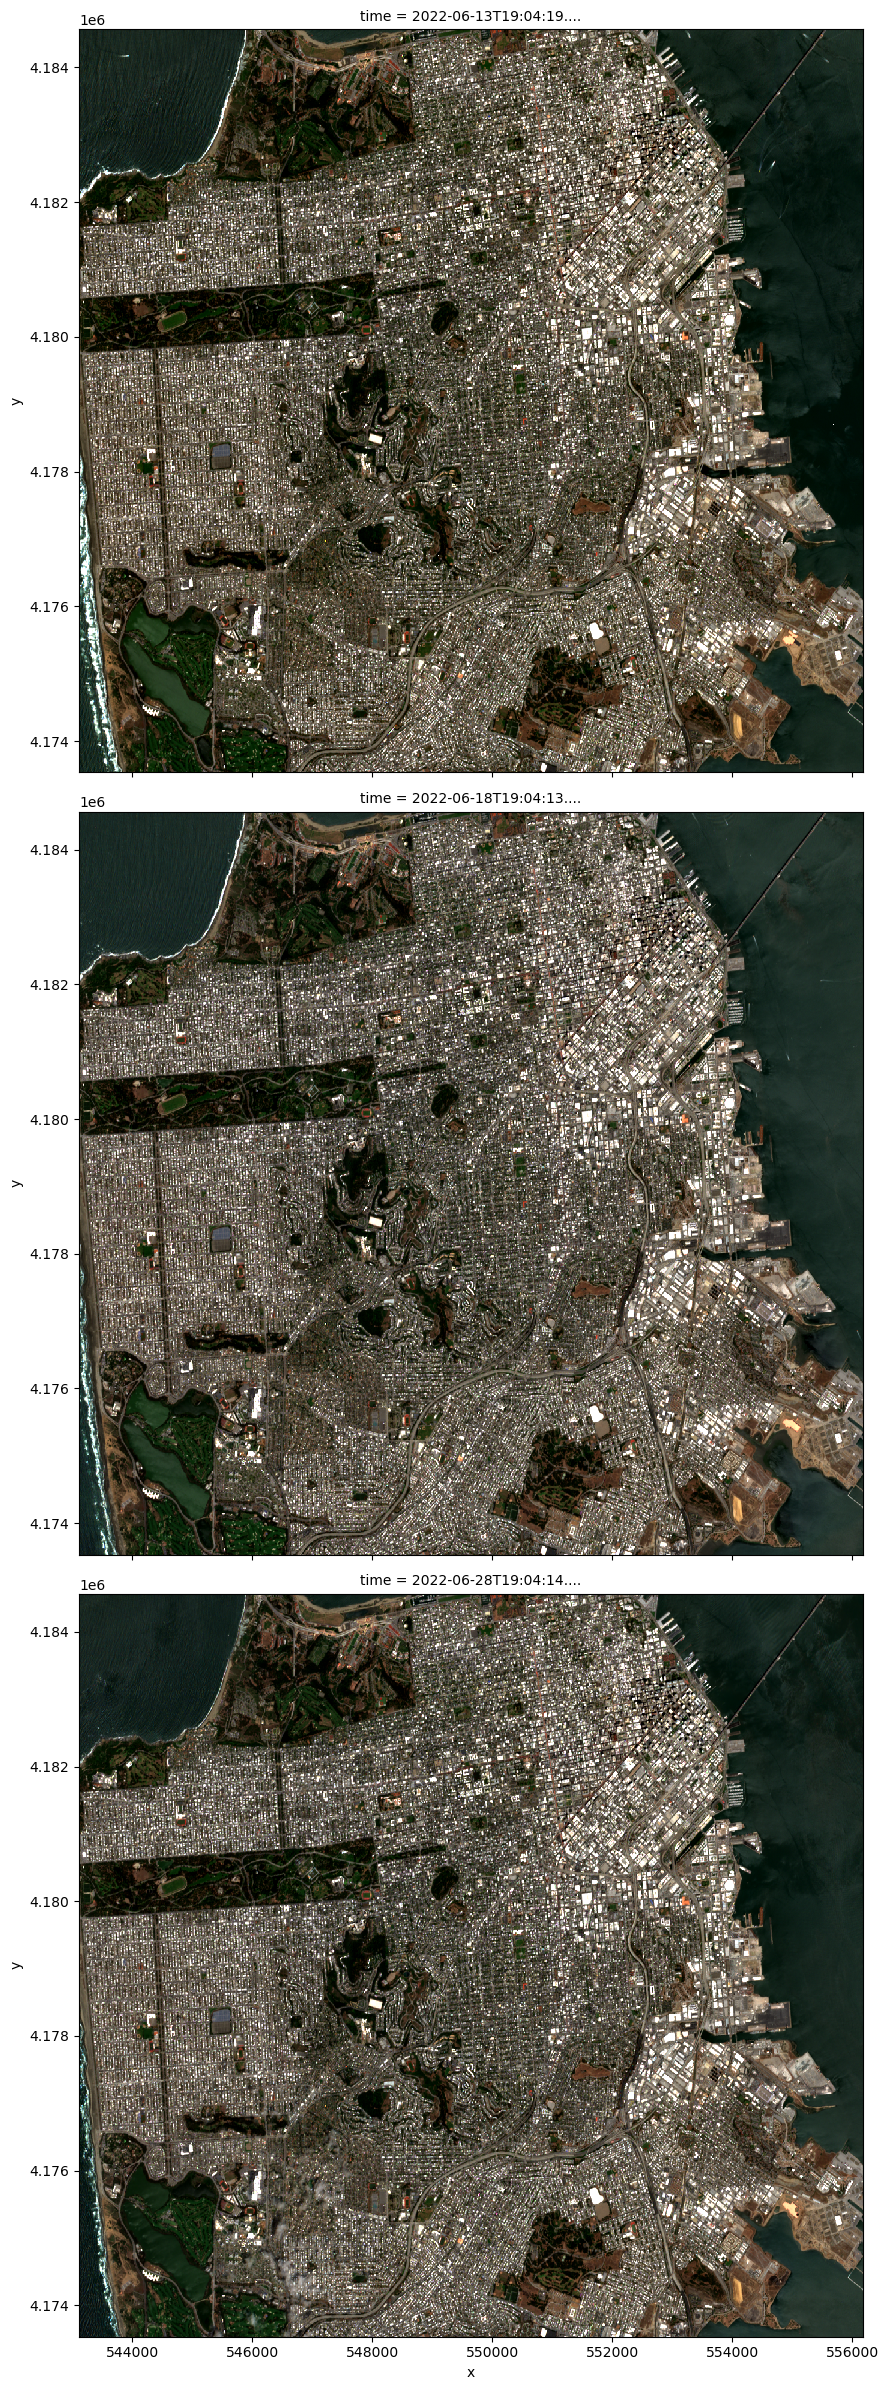

In [8]:

# True-color image, over time
rgb = stack.sel(band=["red", "green", "blue"])
rgb.plot.imshow(row="time", robust=True, add_colorbar=False, size=8)



In [9]:
# import rioxarray
# ndvi.rio.to_raster("ndvi.tif", driver="COG")


## Redlines

In [10]:
!pip install geopandas

In [11]:
import geopandas as gpd
SF_redline = "https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/CASanFrancisco1937.geojson"
poly = gpd.read_file(SF_redline)
poly=poly.set_crs(epsg="4326", allow_override=True)
poly = poly.to_crs(epsg="32610")

In [14]:
poly.head()

name holc_id holc_grade                              area_description_data  \
0   NaN      A1          A  {'1': 'This area consists of 35 irregularly-sh...   
1   NaN     A10          A  {'1': 'This area of 25 irregularly-shaped bloc...   
2   NaN     A11          A  {'1': 'This area, with the exception of the tw...   
3   NaN     A12          A  {'1': 'This area, consisting of some 20 blocks...   
4   NaN     A13          A  {'1': 'This area of some 25 irregularly-shaped...   

                                            geometry  
0  MULTIPOLYGON (((546179.029 4182297.735, 546182...  
1  MULTIPOLYGON (((547501.725 4176623.382, 547490...  
2  MULTIPOLYGON (((547912.587 4177157.885, 547879...  
3  MULTIPOLYGON (((546565.270 4176351.980, 547009...  
4  MULTIPOLYGON (((547490.672 4176630.198, 547501...

## Matching redline vector data with ndvi raster data

In [12]:
!pip install rasterio

In [9]:
trans=stack.transform
trans

Affine(10.0, 0.0, 543120.0,
       0.0, -10.0, 4184560.0)

In [16]:
from rasterio.features import geometry_mask
mskt = geometry_mask(geometries=[poly.iloc[2].geometry], out_shape=ndvi[0].shape, transform=trans, invert=True)
mskf = geometry_mask(geometries=[poly.iloc[2].geometry], out_shape=ndvi[0].shape, transform=trans, invert=False)

mskt.sum(), mskf.sum()

(3237, 1437281)

Inverted mask has true values *inside* the area.

In [22]:
from numpy import ma

# help(ma.masked_array) # uncomment to show why we need invert=False

#### On Mask boolean values

So, with `invert=False` on the geometry_mask, points *outside* of the geometry are set to `True`.
These points are masked out by `ma.masked_array`—--so this is in fact the option that we want:
we want points outside the polygon to be set to true so that the mask erases them.

In [18]:
import numpy.ma as ma
mxt = ma.masked_array(ndvi, mask=mskt)
mxf = ma.masked_array(ndvi, mask=mskf)

mxf.mean()

0.4056860455648554

In [39]:
def polygon_mean(idx, *, single_band_xar, gdf, transform):
    polygon = gdf.iloc[idx].geometry
    grade = gdf.iloc[idx].holc_id
    msk = geometry_mask(geometries=[polygon], out_shape=single_band_xar[0].shape, transform=transform, invert=False)
    if isinstance(grade,str):
        return [ma.masked_array(single_band_xar, mask=msk).mean(), grade, grade[0]]
    else:
        return [ma.masked_array(single_band_xar, mask=msk).mean(), grade, grade]

In [40]:
for i in range(10):
    print(
        polygon_mean(
            single_band_xar=ndvi, 
            gdf=poly,
            idx=i,
            transform=trans
        )
    )

[0.3349971975133889, 'A1', 'A']
[0.43042210916917995, 'A10', 'A']
[0.4056860455648554, 'A11', 'A']
[0.2602530786511333, 'A12', 'A']
[0.3213502613425986, 'A13', 'A']
[0.4057220808622745, 'A2', 'A']
[0.3110044965353012, 'A3', 'A']
[0.24922508443045907, 'A4', 'A']
[0.31640543245460306, 'A5', 'A']
[0.2913218892143486, 'A6', 'A']


In [50]:
import pandas as pd
results = pd.DataFrame(
    [
        polygon_mean(
            single_band_xar=ndvi, 
            gdf=poly,
            idx=i,
            transform=trans
        )
        for i in range(len(poly.index))
    ],
    columns = ['ndvi_mean', 'holc_id', 'redline']
).dropna()

In [51]:
results['ndvi_std']=results.ndvi_mean
results.head()

ndvi_mean holc_id redline  ndvi_std
0   0.334997      A1       A  0.334997
1   0.430422     A10       A  0.430422
2   0.405686     A11       A  0.405686
3   0.260253     A12       A  0.260253
4   0.321350     A13       A  0.321350

In [52]:
results.groupby('redline').agg({'ndvi_mean': 'mean', 'ndvi_std': 'std'})

ndvi_mean  ndvi_std
redline                     
A         0.329570  0.062307
B         0.222573  0.078987
C         0.200837  0.053681
D         0.202815  0.038989